# Práctica 9. Conjuntos de árboles con XGBoost


Greta y Héloïse

Grupo 2

En este notebook estudiaremos cómo crear y visualizar árboles de decisión en scikit-learn. 

In [1]:
RANDOM_STATE=83

## 1) Conjunto de datos

En este notebook vamos a usar el conjunto de datos sobre flores del Iris.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Cargamos el dataset del iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [57]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Estas son las tres clases: 'setosa', 'versicolor', 'virginica'.

In [4]:
import pandas as pd

df = pd.DataFrame(data=iris['data'], columns=iris['feature_names']) 
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Hay cuatro variables: 2 en cuanto al sepal y 2 en cuanto al petal.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


Separamos los datos en entrenamiento, validación y test (60-20-20).

In [6]:
from sklearn.model_selection import train_test_split

# Partimos el conjunto de datos en entrenamiento, validación y test (60-20-20) 
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.2, random_state=RANDOM_STATE, stratify=iris['target'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train) # 0.25 x 0.8 = 0.2


## 2) Modelo de múltiples árboles con XGBoost

Vamos a ver la influencia de los parametros siguientes del Tree Booster : 'eta' (learning rate) y 'lambda' (L2 regularization term on weights). (https://xgboost.readthedocs.io/en/stable/parameter.html)

Primero, usamos el clasificador con los parametros por defecto para ver como se comporta.

La matriz de confusion es 
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
La accuracy es  0.9333333333333333


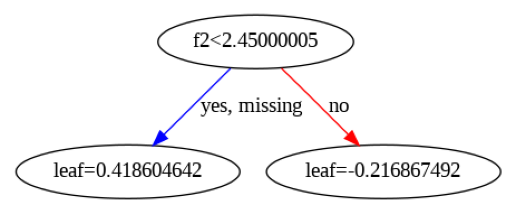

In [60]:
from xgboost import XGBClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix

# parametros por defecto
params = {
    'eta': 0.3, # learning rate
    'lambda': 1 # L2 regularization term on weights
}

# fitting
model = XGBClassifier()
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print("La matriz de confusion es \n", cm)
acc = accuracy_score(y_test, y_pred)
print("La accuracy es ", acc)

# plot tree
plot_tree(model); 

Vemos que el modelo por defecto funciona bastante bien con una accuracy de 93% y mas precisamente, permite reconocer perfectamente los iris de tipo 'setosa' y solo se equivoca en uno de 'versicolor' y uno de 'virginica'.

Ahora, vamos a ver la influencia de los parametros siguientes del XGB Tree Booster : 'eta' (learning rate) y 'lambda' (L2 regularization term on weights) y por eso observamos la evolucion de la accuracy.

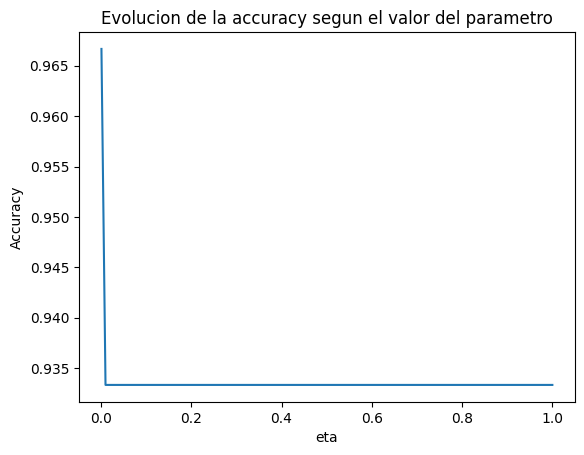

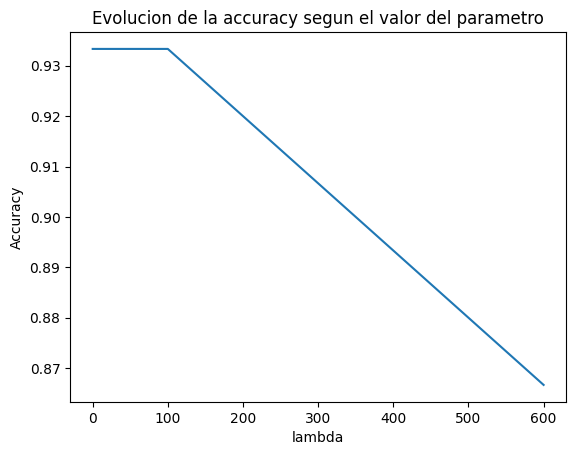

In [63]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_model(params):
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

def plot_param_influence(param_name, param_range):
    scores = []
    for param_value in param_range:
      params = {
          param_name: param_value
      }
      score = train_model(params)
      scores.append(score)
    plt.plot(param_range, scores)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title("Evolucion de la accuracy segun el valor del parametro")
    plt.show()

eta_range = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.8, 1]
lambda_range = [0.000001, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 10, 100, 600]

plot_param_influence('eta', eta_range)
plot_param_influence('lambda', lambda_range)


Con los graficos de la accuracy, vemos que la influencia de los parametros no es muy grande debido al dataset muy pequeno pero podemos ver que la mejor accuracy se obtiene con un "learning rate" (eta) de 0.001 y un lambda menor que 100, entonces conservamos el valor por defecto de 1.

## 3) Modelo optimo

Ahora entrenamos el modelo con los parametros optimos y visualizamos la el resultado de la prediccion con la matriz de confusion y el arbol de decision asociado al modelo.

La matriz de confusion es 
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
La accuracy es  0.9666666666666667
El arbol de decision es


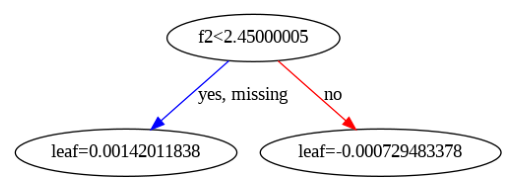

In [59]:
from xgboost import XGBClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

params = {
    'eta': 0.001, # learning rate
    'lambda': 1 # L2 regularization term on weights
}

# fitting con todos los datos de entrenamiento y de validacion
model = XGBClassifier(**params)
x = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
model.fit(x, y)

# prediction
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print("La matriz de confusion es \n", cm)
acc = accuracy_score(y_test, y_pred)
print("La accuracy es ", acc)

# plot tree
print("El arbol de decision es")
plot_tree(model); 

Ahora el modelo con los parametros optimos funciona mejor con un 97% de accuracy (3% mas que antes). Y mas precisamente, permite reconocer perfectamente 2 clases del tipo de iris ahora: 'setosa' y 'virginica'; y solo se equivoca con un dato de la clase 'versicolor'.